<p style="font-size:32px;text-align:center"> <b>Amazon.com - Employee Access Challenge</b> </p>

### Problem statement: 
Predict an employee's access needs, given his/her job role

### Problem Description:
When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

### Data Overview
Taken data from Amazon.com - Employee Access Challenge on kaggle https://www.kaggle.com/c/amazon-employee-access-challenge
The data consists of real historical data collected from 2010 & 2011.  Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees. 
    - Data columns (total 10 columns):  


<table>
  <col width="130">
  <col width="10">
  <tr>
    <th>Column Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>ACTION</td>
    <td>ACTION is 1 if the resource was approved, 0 if the resource was not</td>
  </tr>
  <tr>
    <td>RESOURCE</td>
    <td>An ID for each resource</td>
  </tr>
    <tr>
    <td>MGR_ID</td>
    <td>The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time</td>
  </tr>
    <tr>
    <td>ROLE_ROLLUP_1</td>
    <td>Company role grouping category id 1 (e.g. US Engineering)</td>
  </tr>
    <tr>
    <td>ROLE_ROLLUP_2</td>
    <td>Company role grouping category id 2 (e.g. US Retail)</td>
  </tr>
    <tr>
    <td>ROLE_DEPTNAME</td>
    <td>Company role department description (e.g. Retail)</td>
  </tr>
    <tr>
    <td>ROLE_TITLE</td>
    <td>Company role business title description (e.g. Senior Engineering Retail Manager)</td>
  </tr>
    <tr>
    <td>ROLE_FAMILY_DESC</td>
    <td>Company role family extended description (e.g. Retail Manager, Software Engineering)</td>
  </tr>
    <tr>
    <td>ROLE_FAMILY</td>
    <td>Company role family description (e.g. Retail Manager)
</td>
  </tr>
    <tr>
    <td>ROLE_CODE</td>
    <td>Company role code; this code is unique to each role (e.g. Manager)
</td>
  </tr>
</table>


### Mapping the problem into supervised learning problem:
- Generated new features like Pair wise column featurization. Considered pairs of 2 columns as well as pairs of 3 columns, and analysed if these feature pairs help to improve the model prediction. 

### Business objectives and constraints:  
- The objective of this competition is to build a model, learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.
- Latency is not an issue here.

### Performance metric for supervised learning:  
- AUC (As mentioned in the competition evaluation criteria)

## 1.1 Reading the Train data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer #Equivalent to CountVectorizer followed by TfidfTransformer.

from sklearn.feature_extraction.text import CountVectorizer ##Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

import pickle
import os
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from math import log10
from sklearn.ensemble import RandomForestClassifier

In [2]:
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Changing to the required location in the drive
%cd '/content/drive/My Drive/amazon-employee-access-challenge/'

/content/drive/My Drive/amazon-employee-access-challenge


In [4]:
# Read the train data
result_train = pd.read_csv('train.csv')
print('Number of data points : ', result_train.shape[0])
print('Number of features : ', result_train.shape[1])
print('Features : ', result_train.columns.values)

Number of data points :  32769
Number of features :  10
Features :  ['ACTION' 'RESOURCE' 'MGR_ID' 'ROLE_ROLLUP_1' 'ROLE_ROLLUP_2'
 'ROLE_DEPTNAME' 'ROLE_TITLE' 'ROLE_FAMILY_DESC' 'ROLE_FAMILY' 'ROLE_CODE']


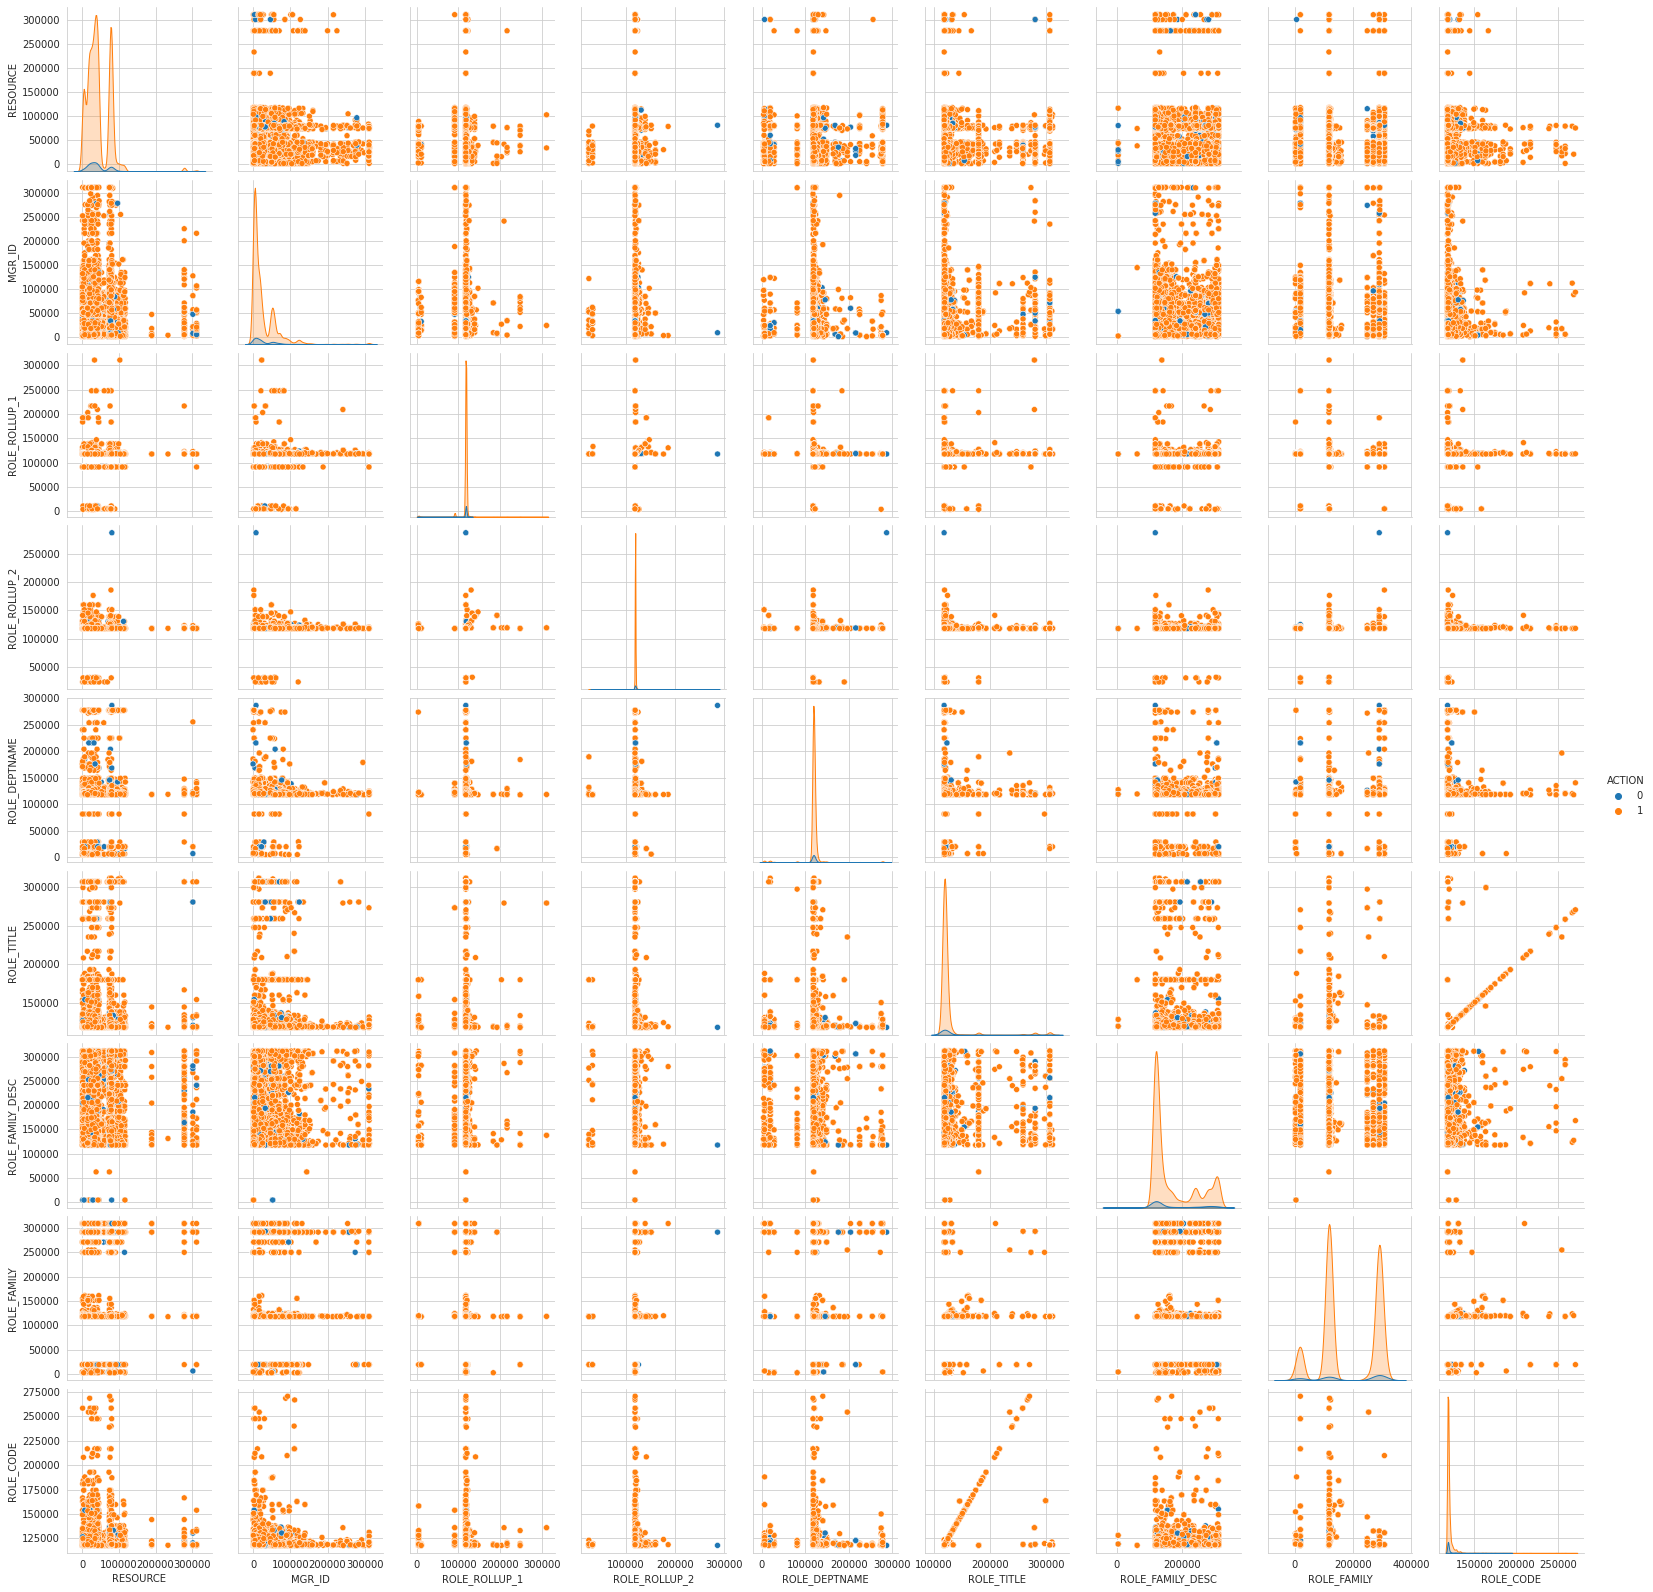

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
# sns.pairplot(result_train, hue="ACTION" , size=6)
# plt.show()
sns.pairplot(result_train, hue="ACTION")

In [7]:
# Get the total categories present in each column of the dataframe
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html

result_train.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

ROLE_TITLE and ROLE_CODE have the exact same number of categories. Hence there is a possibility that every unique  ROLE_TITLE is mapped to an unique ROLE_CODE. Let's investigate this a little further

In [8]:
# Let's drop the duplicate rows accross 'ROLE_TITLE'and 'ROLE_CODE' except the first occurence and get the shape
# IF the Unique values is still 343 for both 'ROLE_TITLE' and 'ROLE_CODE'
# then it means that there is a one to one mapping

result_train.drop_duplicates(subset=['ROLE_TITLE', 'ROLE_CODE']).nunique()

ACTION                2
RESOURCE            242
MGR_ID              320
ROLE_ROLLUP_1        60
ROLE_ROLLUP_2        75
ROLE_DEPTNAME       174
ROLE_TITLE          343
ROLE_FAMILY_DESC    295
ROLE_FAMILY          67
ROLE_CODE           343
dtype: int64

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [ ]:
#count NaN values in coumn in dataframe
result_train.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

In [ ]:
#count of each class in dataframe: https://stackoverflow.com/questions/36004976/count-frequency-of-values-in-pandas-dataframe-column
result_train.ACTION.value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

## 1.2 Data Analysis

Number of Samples that are approved  30872 , ( 94.21099209618848 %)
Number of projects thar are not approved  1897 , ( 5.789007903811529 %)


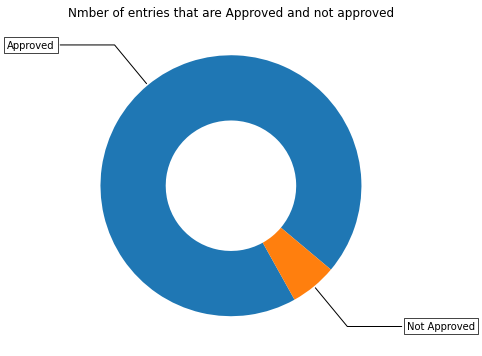

In [ ]:
# PROVIDE CITATIONS TO YOUR CODE IF YOU TAKE IT FROM ANOTHER WEBSITE.
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py


y_value_counts = result_train['ACTION'].value_counts()
print("Number of Samples that are approved ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Approved", "Not Approved"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of entries that are Approved and not approved")

plt.show()

__Summary__
: From above As we can see that MGR_ID and Resource has so many categories

In [ ]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(result_train.groupby("ROLE_ROLLUP_1")["ACTION"].apply(np.mean)).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage
temp.columns = ['ROLE_ROLLUP_1', 'Approval Ratio']

In [ ]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['Approval Ratio'], inplace=True)
print("role grouping category with lowest % approvals")
print(temp.head(5))
print('='*50)
print("role grouping category with highest % approvals")
print(temp.tail(5))

role grouping category with lowest % approvals
   ROLE_ROLLUP_1  Approval Ratio
98        121411        0.000000
48        118256        0.734545
38        118138        0.761905
20        117978        0.774194
89        119920        0.775862
role grouping category with highest % approvals
   ROLE_ROLLUP_1  Approval Ratio
93        120354             1.0
29        118074             1.0
96        120883             1.0
81        119370             1.0
63        118670             1.0


__Summary: __
1. Since there is some variability in % approvals with respect to ROLE_ROLLUP_1, therefore we can conclude that the ROLE_ROLLUP_1 feature has some importance in predicting the final outcome(i.e whether the Resource will be approved or not)

In [ ]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='ACTION', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Resources')
    plt.title('Number of resources aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [ ]:
def univariate_barplots(data, col1, col2='ACTION', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(result_train.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(result_train.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(result_train.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

#### 1.2.1 Univariate Analysis of ROLE_ROLLUP_1

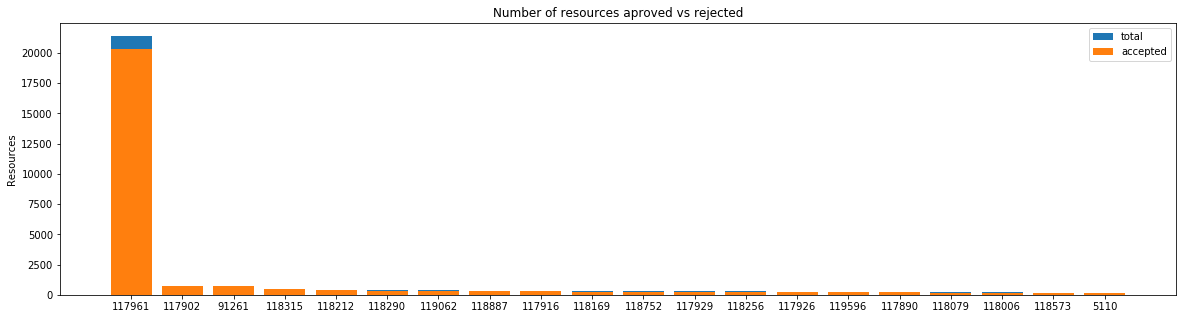

    ROLE_ROLLUP_1  ACTION  total       Avg
18         117961   20320  21407  0.949222
6          117902     714    742  0.962264
127         91261     695    721  0.963939
51         118315     474    498  0.951807
45         118212     385    400  0.962500
    ROLE_ROLLUP_1  ACTION  total       Avg
4          117890     225    234  0.961538
30         118079     179    221  0.809955
27         118006     170    197  0.862944
58         118573     182    190  0.957895
126          5110     183    186  0.983871


In [ ]:
univariate_barplots(result_train, 'ROLE_ROLLUP_1', 'ACTION', 20)

__Summary: __
1. Resource with ROLL_ROLEUP_1 = 117961 has appeared the most(21407 times out of 32767 times).
2. Not much variability for different ROLE_ROLLUP_1. Hence the ML model may not give much importance to this feature.

#### 1.2.2 Univariate Analysis of ROLE_ROLLUP_2

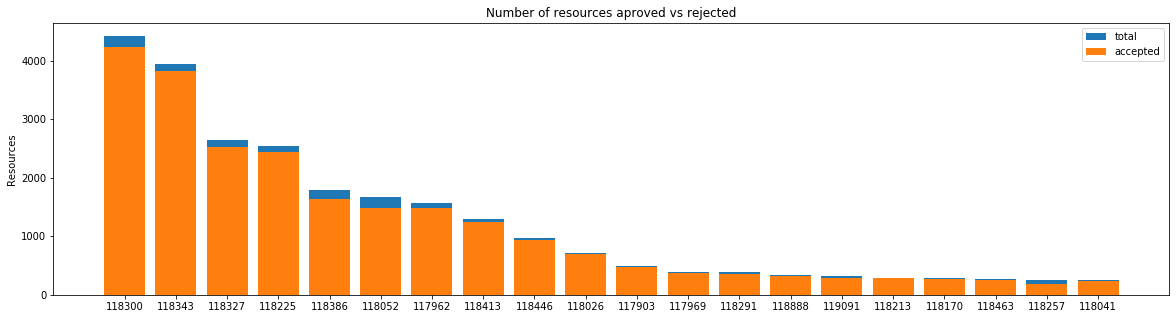

   ROLE_ROLLUP_2  ACTION  total       Avg
61        118300    4230   4424  0.956148
65        118343    3823   3945  0.969075
63        118327    2521   2641  0.954563
55        118225    2438   2547  0.957205
68        118386    1639   1796  0.912584
   ROLE_ROLLUP_2  ACTION  total       Avg
52        118213     289    295  0.979661
47        118170     262    291  0.900344
72        118463     258    267  0.966292
57        118257     185    257  0.719844
32        118041     238    253  0.940711


In [ ]:
univariate_barplots(result_train, 'ROLE_ROLLUP_2', 'ACTION', 20)

__Summary: __
1. Resource with ROLL_ROLEUP_2 = 118300 has appeared the most
2. Resource with ROLL_ROLEUP_2 = 118343 has highest approval rate
3. Lot of variability for different ROLE_ROLLUP_2

#### 1.2.3 Univariate Analysis of ROLE_DEPTNAME

> Indented block



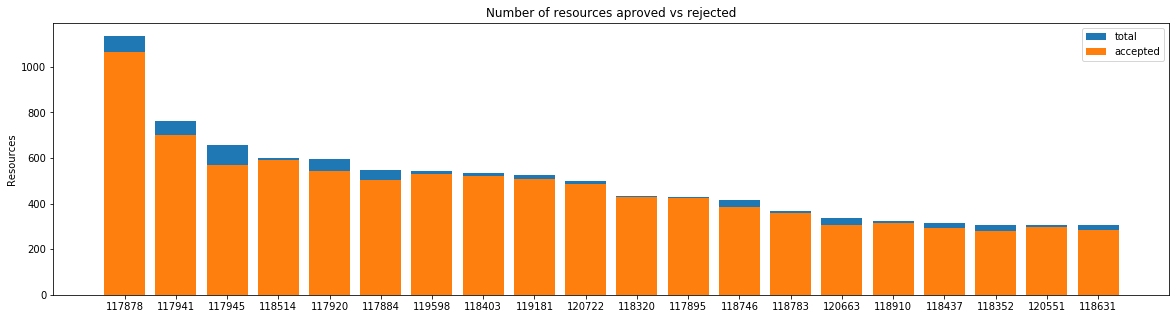

   ROLE_DEPTNAME  ACTION  total       Avg
0         117878    1064   1135  0.937445
6         117941     700    763  0.917431
7         117945     570    659  0.864947
57        118514     589    601  0.980033
5         117920     541    597  0.906198
    ROLE_DEPTNAME  ACTION  total       Avg
104        118910     313    325  0.963077
46         118437     295    317  0.930599
32         118352     279    305  0.914754
206        120551     298    304  0.980263
74         118631     282    304  0.927632


In [ ]:
univariate_barplots(result_train, 'ROLE_DEPTNAME', 'ACTION', 20)

__Summary: __
1. Resource with ROLE_DEPTNAME = 117878 has appeared the most
2. Resource with ROLE_DEPTNAME = 117878 has the highest approval rate
3. Lot of variability for different ROLE_DEPTNAME

#### 1.2.4 Univariate Analysis of ROLE_TITLE

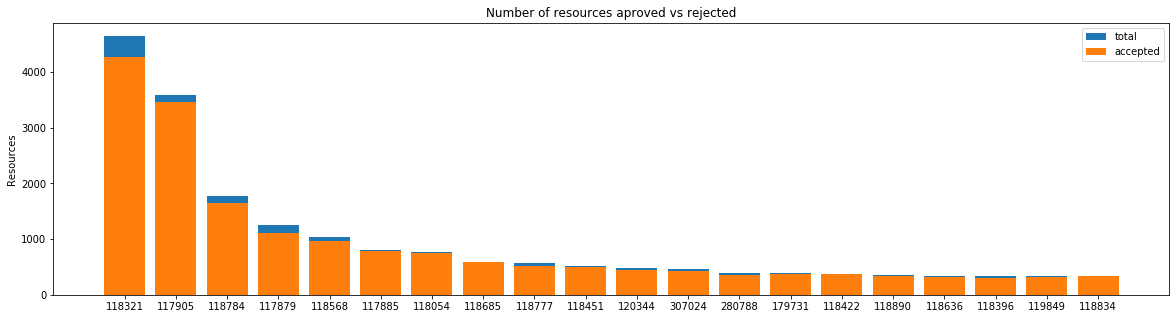

   ROLE_TITLE  ACTION  total       Avg
22     118321    4279   4649  0.920413
4      117905    3467   3583  0.967625
47     118784    1647   1772  0.929458
0      117879    1117   1256  0.889331
36     118568     965   1043  0.925216
   ROLE_TITLE  ACTION  total       Avg
56     118890     333    347  0.959654
37     118636     324    344  0.941860
26     118396     306    342  0.894737
83     119849     311    337  0.922849
53     118834     331    335  0.988060


In [ ]:
univariate_barplots(result_train, 'ROLE_TITLE', 'ACTION', 20)

__Summary: __
1. Resource with ROLE_TITLE = 117905  has highest rate of approval
2. Resource with ROLE_TITLE = 118321  has appeared the most
3. Lot of variability for different ROLE_TITLE

#### 1.2.5 Univariate Analysis of ROLE_FAMILY_DESC

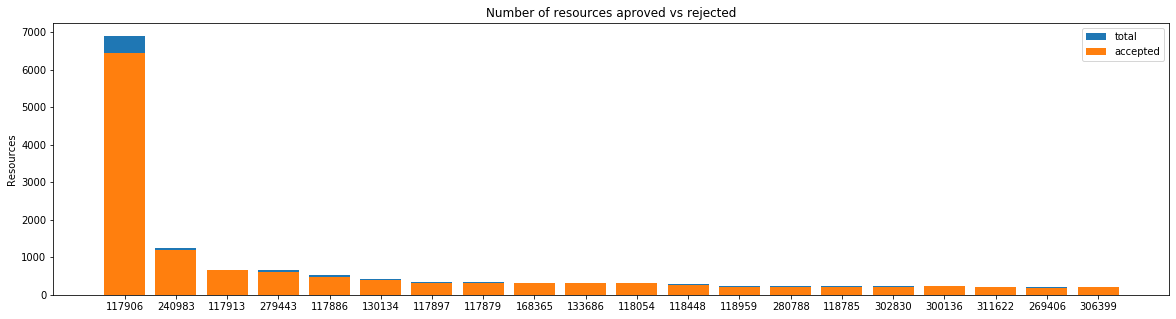

     ROLE_FAMILY_DESC  ACTION  total       Avg
5              117906    6437   6896  0.933440
1899           240983    1189   1244  0.955788
6              117913     649    670  0.968657
2141           279443     615    665  0.924812
1              117886     478    530  0.901887
     ROLE_FAMILY_DESC  ACTION  total       Avg
2256           302830     203    225  0.902222
2236           300136     222    222  1.000000
2344           311622     195    219  0.890411
2091           269406     177    211  0.838863
2278           306399     197    205  0.960976


In [ ]:
univariate_barplots(result_train, 'ROLE_FAMILY_DESC', 'ACTION', 20)

__Summary: __
1. Resource with ROLE_FAMILY_DESC = 117906 has appeared the most and has fairly high rate of approval
2. Resource with ROLE_FAMILY_DESC = 300136 are all aprroved.
2. Lot of variability for different ROLE_FAMILY_DESC

#### 1.2.6 Univariate Analysis of ROLE_FAMILY  

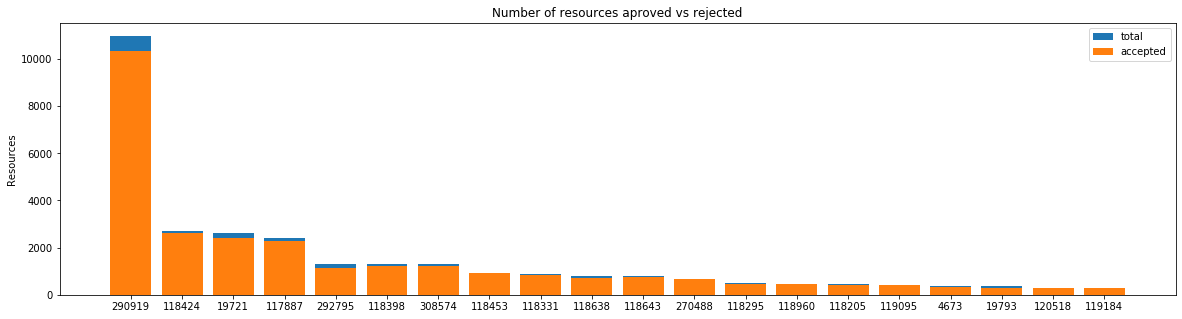

   ROLE_FAMILY  ACTION  total       Avg
61      290919   10347  10980  0.942350
9       118424    2616   2690  0.972491
56       19721    2393   2636  0.907815
0       117887    2302   2400  0.959167
62      292795    1137   1318  0.862671
   ROLE_FAMILY  ACTION  total       Avg
25      119095     406    412  0.985437
65        4673     332    384  0.864583
57       19793     303    362  0.837017
34      120518     291    294  0.989796
26      119184     283    293  0.965870


In [ ]:
univariate_barplots(result_train, 'ROLE_FAMILY', 'ACTION', 20)

__Summary: __
1. Resource with ROLE_FAMILY = 290919 has appeared the most and has highest rate of approval
2. Lot of variability for different ROLE_FAMILY

#### 1.2.7 Univariate Analysis of ROLE_CODE  

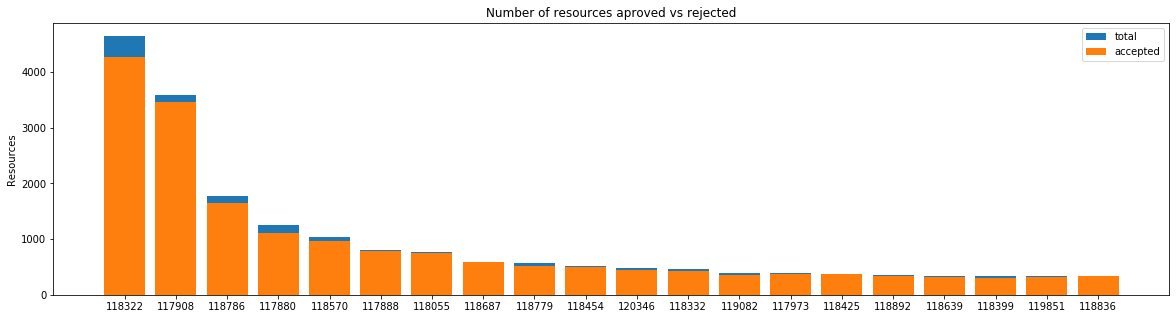

   ROLE_CODE  ACTION  total       Avg
23    118322    4279   4649  0.920413
4     117908    3467   3583  0.967625
51    118786    1647   1772  0.929458
0     117880    1117   1256  0.889331
40    118570     965   1043  0.925216
   ROLE_CODE  ACTION  total       Avg
60    118892     333    347  0.959654
41    118639     324    344  0.941860
27    118399     306    342  0.894737
91    119851     311    337  0.922849
57    118836     331    335  0.988060


In [ ]:
univariate_barplots(result_train, 'ROLE_CODE', 'ACTION', 20)

__Summary: __
1. Resource with ROLE_FROLE_CODE = 290919 has appeared the most and has highest rate of approval
2. Lot of variability for different ROLE_CODE

# 2.Preparing data for Models

**First Convert the Columns in Train to str**

In [5]:
# We need to convert the columns to string as countVectorizer will not work with integer values
# https://www.geeksforgeeks.org/change-data-type-for-one-or-more-columns-in-pandas-dataframe/

convert_dict = {'RESOURCE': str, 
                'MGR_ID': str, 'ROLE_ROLLUP_1': str, 'ROLE_ROLLUP_2': str, 'ROLE_DEPTNAME': str, 'ROLE_TITLE': str,
                'ROLE_FAMILY_DESC': str,'ROLE_FAMILY': str,'ROLE_CODE': str
               } 

result_train = result_train.astype(convert_dict)  # Because countVectorizer will not work with integer values, hence we are converting the columns to str

result_train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


**Convert the Columns in Test to str**

In [6]:
result_test = pd.read_csv('test.csv')
print('Number of data points : ', result_test.shape[0])
print('Number of features : ', result_test.shape[1])
print('Features : ', result_test.columns.values)
convert_dict = {'RESOURCE': str, 
                'MGR_ID': str, 'ROLE_ROLLUP_1': str, 'ROLE_ROLLUP_2': str, 'ROLE_DEPTNAME': str, 'ROLE_TITLE': str,
                'ROLE_FAMILY_DESC': str,'ROLE_FAMILY': str,'ROLE_CODE': str
               } 

result_test = result_test.astype(convert_dict)  # Because countVectorizer will not work with integer values


Number of data points :  58921
Number of features :  10
Features :  ['id' 'RESOURCE' 'MGR_ID' 'ROLE_ROLLUP_1' 'ROLE_ROLLUP_2' 'ROLE_DEPTNAME'
 'ROLE_TITLE' 'ROLE_FAMILY_DESC' 'ROLE_FAMILY' 'ROLE_CODE']


In [7]:
# drop the ACTION column from the train data
y_true = result_train['ACTION'].values
result_train = result_train.drop(['ACTION', 'ROLE_TITLE'], axis=1)
result_test = result_test.drop(['id','ROLE_TITLE'], axis=1)

Apply TSNE to check if train data is separable based on ACTION

In [ ]:
# Code is taken from AAIC tutorial notebooks

# https://stackoverflow.com/questions/43757820/how-to-add-a-variable-to-python-plt-title/43758816

import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

def plot_TSNE(x,y,perplexity):
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=200)

    tsne_data = tsne.fit_transform(x)
    # if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

    tsne_data = np.vstack((tsne_data.T, y)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne
    sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
    plt.title('TSNE with BOW encoding of project_title feature and PERPLEXITY=%s ' %perplexity)
    plt.show()


    

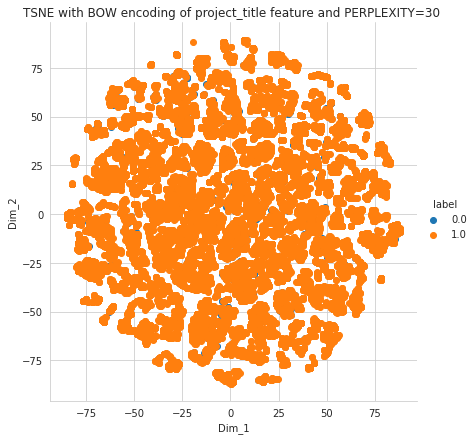

In [ ]:
x= result_train
y= y_true

plot_TSNE(x,y,30)

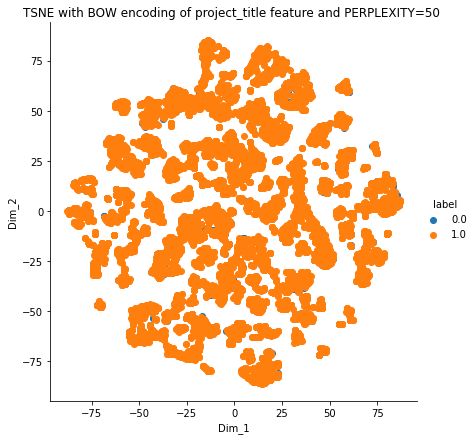

In [ ]:
plot_TSNE(x,y,50)

TSNE is not able to separate the data

## 2.1 PairWise featurization(of degree 2) for Train data

In [8]:
# https://stackoverflow.com/questions/43347939/all-possible-combinations-of-columns-in-dataframe-pandas-python
# this helper function combines columns in pairs of 2. We will find out if this feature engineering technique creates a better ML model
# the result of pairing is columnX_columnY
def group_data_2(res):
  df = res
  cc = list(combinations(df.columns,2))
  df = pd.concat([df[c[0]] + '_' + df[c[1]] for c in cc], axis=1, keys=cc)
  df.columns = df.columns.map('_'.join)
  return df

In [9]:
# this function combines columns in pair of 3
# the result of pairing is columnX_columnY_columnZ
def group_data_3(res):
  df = res
  cc = list(combinations(df.columns,3))
  df = pd.concat([df[c[0]] + '_' + df[c[1]] + '_' + df[c[2]] for c in cc], axis=1, keys=cc)
  df.columns = df.columns.map('_'.join)
  return df

In [ ]:
# this function combines columns in pair of 4
# the result of pairing is columnX_columnY_columnZ
def group_data_4(res):
  df = res
  cc = list(combinations(df.columns,4))
  df = pd.concat([df[c[0]] + '_' + df[c[1]] + '_' + df[c[2]] + '_' + df[c[3]] for c in cc], axis=1, keys=cc)
  df.columns = df.columns.map('_'.join)
  return df

In [ ]:
result_train.dtypes

RESOURCE            object
MGR_ID              object
ROLE_ROLLUP_1       object
ROLE_ROLLUP_2       object
ROLE_DEPTNAME       object
ROLE_FAMILY_DESC    object
ROLE_FAMILY         object
ROLE_CODE           object
dtype: object

In [10]:
from itertools import combinations
result2 = group_data_2(result_train)
result3 = group_data_3(result_train)
# result4 = group_data_4(result_train)
frames = [result_train,result2,result3]
result_train = pd.concat(frames,axis=1)

pickle_out = open("result_train.pickle","wb")
pickle.dump(result_train, pickle_out)
pickle_out.close()

In [11]:
# lets see the new columns that are formed in the training data. 
# The total columns should be 8C2 + 8C3 + 8 = 92
print(result_train.columns)
print('-'*100)
print("Total number of columns in Train are: ",len(result_train.columns))

Index(['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE', 'RESOURCE_MGR_ID',
       'RESOURCE_ROLE_ROLLUP_1', 'RESOURCE_ROLE_ROLLUP_2',
       'RESOURCE_ROLE_DEPTNAME', 'RESOURCE_ROLE_FAMILY_DESC',
       'RESOURCE_ROLE_FAMILY', 'RESOURCE_ROLE_CODE', 'MGR_ID_ROLE_ROLLUP_1',
       'MGR_ID_ROLE_ROLLUP_2', 'MGR_ID_ROLE_DEPTNAME',
       'MGR_ID_ROLE_FAMILY_DESC', 'MGR_ID_ROLE_FAMILY', 'MGR_ID_ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE', 'RESOURCE_M

Since we have added so many new features in the dataset, lets see if the TSNE plot is able to separate the class labels

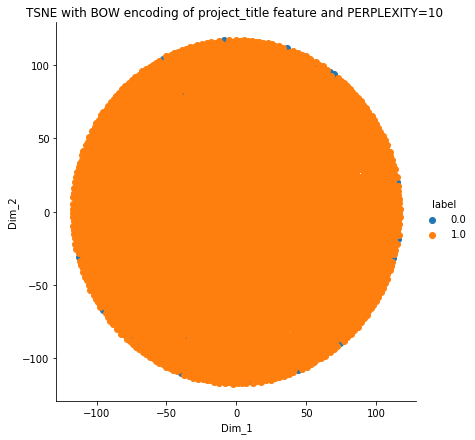

In [ ]:
plot_TSNE(x,y,10)

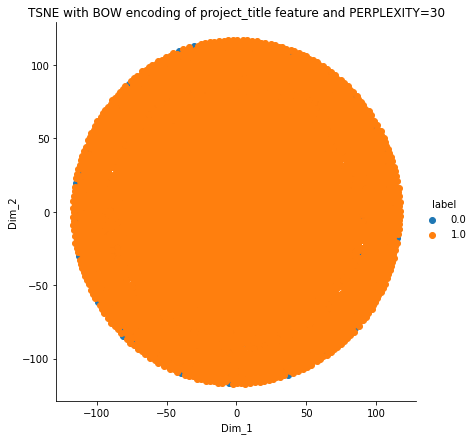

In [ ]:
x= result_train
y= y_true

plot_TSNE(x,y,30)

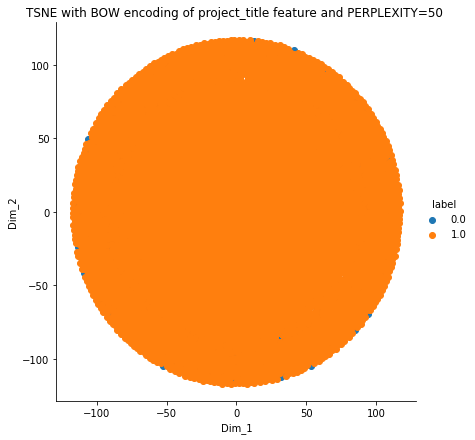

In [ ]:
x= result_train
y= y_true
plot_TSNE(x,y,50)

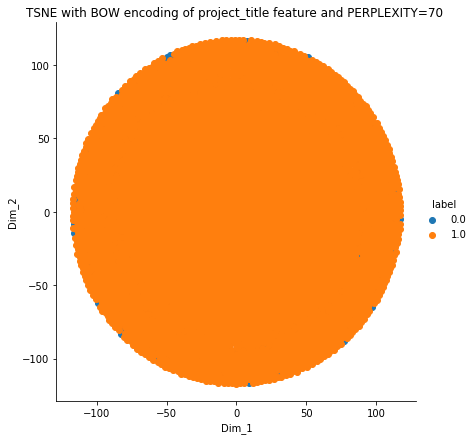

In [ ]:
plot_TSNE(x,y,70)

## 2.2 PairWise featurization(of degree 2) for Test data

In [12]:
# feature engineering: combining columns in pairs of 2
# the result is columnX_columnY and then concatinating all the singular columns with the resultant pairwise combination.
result2 = group_data_2(result_test)
result3 = group_data_3(result_test)
# result4 = group_data_4(result_test)
frames = [result_test,result2,result3]
result_test = pd.concat(frames,axis=1)

In [13]:
# lets see the new columns that are formed in the training data. 
# The total columns should be 8C2 + 8C3 + 8 = 92
print(result_test.columns)
print('-'*100)
print("Total number of columns in Test are: ",len(result_test.columns))

Index(['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME',
       'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE', 'RESOURCE_MGR_ID',
       'RESOURCE_ROLE_ROLLUP_1', 'RESOURCE_ROLE_ROLLUP_2',
       'RESOURCE_ROLE_DEPTNAME', 'RESOURCE_ROLE_FAMILY_DESC',
       'RESOURCE_ROLE_FAMILY', 'RESOURCE_ROLE_CODE', 'MGR_ID_ROLE_ROLLUP_1',
       'MGR_ID_ROLE_ROLLUP_2', 'MGR_ID_ROLE_DEPTNAME',
       'MGR_ID_ROLE_FAMILY_DESC', 'MGR_ID_ROLE_FAMILY', 'MGR_ID_ROLE_CODE',
       'ROLE_ROLLUP_1_ROLE_ROLLUP_2', 'ROLE_ROLLUP_1_ROLE_DEPTNAME',
       'ROLE_ROLLUP_1_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_1_ROLE_FAMILY',
       'ROLE_ROLLUP_1_ROLE_CODE', 'ROLE_ROLLUP_2_ROLE_DEPTNAME',
       'ROLE_ROLLUP_2_ROLE_FAMILY_DESC', 'ROLE_ROLLUP_2_ROLE_FAMILY',
       'ROLE_ROLLUP_2_ROLE_CODE', 'ROLE_DEPTNAME_ROLE_FAMILY_DESC',
       'ROLE_DEPTNAME_ROLE_FAMILY', 'ROLE_DEPTNAME_ROLE_CODE',
       'ROLE_FAMILY_DESC_ROLE_FAMILY', 'ROLE_FAMILY_DESC_ROLE_CODE',
       'ROLE_FAMILY_ROLE_CODE', 'RESOURCE_M

In [ ]:
result_test.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_MGR_ID,RESOURCE_ROLE_ROLLUP_1,RESOURCE_ROLE_ROLLUP_2,RESOURCE_ROLE_DEPTNAME,RESOURCE_ROLE_FAMILY_DESC,RESOURCE_ROLE_FAMILY,RESOURCE_ROLE_CODE,MGR_ID_ROLE_ROLLUP_1,MGR_ID_ROLE_ROLLUP_2,MGR_ID_ROLE_DEPTNAME,MGR_ID_ROLE_FAMILY_DESC,MGR_ID_ROLE_FAMILY,MGR_ID_ROLE_CODE,ROLE_ROLLUP_1_ROLE_ROLLUP_2,ROLE_ROLLUP_1_ROLE_DEPTNAME,ROLE_ROLLUP_1_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_CODE,ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_DEPTNAME_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_FAMILY_DESC_ROLE_CODE,ROLE_FAMILY_ROLE_CODE,RESOURCE_MGR_ID_ROLE_ROLLUP_1,RESOURCE_MGR_ID_ROLE_ROLLUP_2,RESOURCE_MGR_ID_ROLE_DEPTNAME,RESOURCE_MGR_ID_ROLE_FAMILY_DESC,...,RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY,RESOURCE_ROLE_DEPTNAME_ROLE_CODE,RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY,RESOURCE_ROLE_FAMILY_DESC_ROLE_CODE,RESOURCE_ROLE_FAMILY_ROLE_CODE,MGR_ID_ROLE_ROLLUP_1_ROLE_ROLLUP_2,MGR_ID_ROLE_ROLLUP_1_ROLE_DEPTNAME,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY_DESC,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY,MGR_ID_ROLE_ROLLUP_1_ROLE_CODE,MGR_ID_ROLE_ROLLUP_2_ROLE_DEPTNAME,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY_DESC,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY,MGR_ID_ROLE_ROLLUP_2_ROLE_CODE,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY_DESC,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY,MGR_ID_ROLE_DEPTNAME_ROLE_CODE,MGR_ID_ROLE_FAMILY_DESC_ROLE_FAMILY,MGR_ID_ROLE_FAMILY_DESC_ROLE_CODE,MGR_ID_ROLE_FAMILY_ROLE_CODE,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_CODE,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_CODE,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_ROLLUP_1_ROLE_FAMILY_ROLE_CODE,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_CODE,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_ROLLUP_2_ROLE_FAMILY_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY_ROLE_CODE
0,78766,72734,118079,118080,117878,118177,19721,117880,78766_72734,78766_118079,78766_118080,78766_117878,78766_118177,78766_19721,78766_117880,72734_118079,72734_118080,72734_117878,72734_118177,72734_19721,72734_117880,118079_118080,118079_117878,118079_118177,118079_19721,118079_117880,118080_117878,118080_118177,118080_19721,118080_117880,117878_118177,117878_19721,117878_117880,118177_19721,118177_117880,19721_117880,78766_72734_118079,78766_72734_118080,78766_72734_117878,78766_72734_118177,...,78766_117878_19721,78766_117878_117880,78766_118177_19721,78766_118177_117880,78766_19721_117880,72734_118079_118080,72734_118079_117878,72734_118079_118177,72734_118079_19721,72734_118079_117880,72734_118080_117878,72734_118080_118177,72734_118080_19721,72734_118080_117880,72734_117878_118177,72734_117878_19721,72734_117878_117880,72734_118177_19721,72734_118177_117880,72734_19721_117880,118079_118080_117878,118079_118080_118177,118079_118080_19721,118079_118080_117880,118079_117878_118177,118079_117878_19721,118079_117878_117880,118079_118177_19721,118079_118177_117880,118079_19721_117880,118080_117878_118177,118080_117878_19721,118080_117878_117880,118080_118177_19721,118080_118177_117880,118080_19721_117880,117878_118177_19721,117878_118177_117880,117878_19721_117880,118177_19721_117880
1,40644,4378,117961,118327,118507,122008,118398,118865,40644_4378,40644_117961,40644_118327,40644_118507,40644_122008,40644_118398,40644_118865,4378_117961,4378_118327,4378_118507,4378_122008,4378_118398,4378_118865,117961_118327,117961_118507,117961_122008,117961_118398,117961_118865,118327_11

# 3.Frequency encoding

In [ ]:
freq_frame = {}
combined_data = pd.concat([result_train, result_test], ignore_index = True)
new_dataset = pd.DataFrame()
for col in result_train.columns:
    data = combined_data.groupby([col]).size().reset_index()
    freq = combined_data[[col]].merge(data, on = col, how = "left")[0]
    new_dataset[col+"_freq"] = freq
    combined_data[col+"_freq"] = freq

    freq2 = (combined_data[[col,col+"_freq"]].groupby(col)[col+"_freq"].mean())
    freq_frame[col] = freq2

train_freq = new_dataset[:result_train.shape[0]]
test_freq =  new_dataset[result_train.shape[0]:]


pickle_out = open("freq_frame.pickle","wb")
pickle.dump(freq_frame, pickle_out)
pickle_out.close()

In [ ]:
print("Shape of train_freq dataframe: ", train_freq.shape)
print("Shape of test_freq dataframe: ",test_freq.shape)

Shape of train_freq dataframe:  (32769, 92)
Shape of test_freq dataframe:  (58921, 92)


In [ ]:
train_freq.head()

,RESOURCE_freq,MGR_ID_freq,ROLE_ROLLUP_1_freq,ROLE_ROLLUP_2_freq,ROLE_DEPTNAME_freq,ROLE_FAMILY_DESC_freq,ROLE_FAMILY_freq,ROLE_CODE_freq,RESOURCE_MGR_ID_freq,RESOURCE_ROLE_ROLLUP_1_freq,RESOURCE_ROLE_ROLLUP_2_freq,RESOURCE_ROLE_DEPTNAME_freq,RESOURCE_ROLE_FAMILY_DESC_freq,RESOURCE_ROLE_FAMILY_freq,RESOURCE_ROLE_CODE_freq,MGR_ID_ROLE_ROLLUP_1_freq,MGR_ID_ROLE_ROLLUP_2_freq,MGR_ID_ROLE_DEPTNAME_freq,MGR_ID_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_FAMILY_freq,MGR_ID_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_freq,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_1_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_freq,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_2_ROLE_FAMILY_freq,ROLE_ROLLUP_2_ROLE_CODE_freq,ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,ROLE_DEPTNAME_ROLE_FAMILY_freq,ROLE_DEPTNAME_ROLE_CODE_freq,ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_FAMILY_ROLE_CODE_freq,RESOURCE_MGR_ID_ROLE_ROLLUP_1_freq,RESOURCE_MGR_ID_ROLE_ROLLUP_2_freq,RESOURCE_MGR_ID_ROLE_DEPTNAME_freq,RESOURCE_MGR_ID_ROLE_FAMILY_DESC_freq,...,RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY_freq,RESOURCE_ROLE_DEPTNAME_ROLE_CODE_freq,RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,RESOURCE_ROLE_FAMILY_DESC_ROLE_CODE_freq,RESOURCE_ROLE_FAMILY_ROLE_CODE_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_ROLLUP_2_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_DEPTNAME_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_CODE_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_DEPTNAME_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_CODE_freq,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY_freq,MGR_ID_ROLE_DEPTNAME_ROLE_CODE_freq,MGR_ID_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,MGR_ID_ROLE_FAMILY_DESC_ROLE_CODE_freq,MGR_ID_ROLE_FAMILY_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_DEPTNAME_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_FAMILY_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_FAMILY_ROLE_CODE_freq,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_DEPTNAME_ROLE_FAMILY_ROLE_CODE_freq,ROLE_FAMILY_DESC_ROLE_FAMILY_ROLE_CODE_freq
0,7,145,59065,12155,180,17996,28861,9569,6,7,7,1,4,5,2,145,145,28,96,116,33,12155,162,15464,24888,7788,162,2818,4395,1234,132,156,43,17869,6932,9569,6,6,1,4,...,1,1,4,2,2,145,28,96,116,33,28,96,116,33,14,14,14,96,33,33,162,2818,4395,1234,118,138,32,15429,5664,7788,118,138,32,2818,962,1234,132,39,43,6932
1,93,34,59065,10920,406,29,3506,213,1,82,26,2,1,4,2,34,34,34,10,10,10,10920,313,29,3069,213,307,10,572,50,10,107,10,29,29,213,1,1,1,1,...,1,1,1,1,2,34,34,10,10,10,34,10,10,10,10,10,10,10,10,10,307,10,572,50,10,107,10,29,29,213,10,101,10,10,10,50,10,10,10,29
2,8,7,518,518,1645,92,7768,3838,1,8,8,5,1,7,3,2,2,2,2,3,2,518,27,3,360,157,27,3,360,157,3,910,576,80,3,3838,1,1,1,1,...,5,3,1,1,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,27,3,360,157,3,21,13,3,3,157,3,21,13,3,3,157,3,3,576,3
3,2,153,59065,10920,494,3244,28861,12082,1,2,1,1,1,2,1,153,153,117,39,91,65,10920,435,3147,24888,10702,398,660,4299,1852,132,391,244,3244,1385,12082,1,1,1,1,...,1,1,1,1,1,153,117,39,91,65,117,39,91,65,39,91,65,39,39,65,398,660,4299,1852,132,332,243,3147,1361,10702,108,300,211,660,327,1852,132,115,244,1385
4,28,18,815,396,143,41,945,187,2,5,2,2,3,18,6,18,18,3,12,18,12,396,60,21,46,37,46,12,18,12,12,12,12,37,37,187,2,2,1,2,

In [ ]:
test_freq = test_freq.reset_index(drop=True)


In [ ]:
test_freq.head()

,RESOURCE_freq,MGR_ID_freq,ROLE_ROLLUP_1_freq,ROLE_ROLLUP_2_freq,ROLE_DEPTNAME_freq,ROLE_FAMILY_DESC_freq,ROLE_FAMILY_freq,ROLE_CODE_freq,RESOURCE_MGR_ID_freq,RESOURCE_ROLE_ROLLUP_1_freq,RESOURCE_ROLE_ROLLUP_2_freq,RESOURCE_ROLE_DEPTNAME_freq,RESOURCE_ROLE_FAMILY_DESC_freq,RESOURCE_ROLE_FAMILY_freq,RESOURCE_ROLE_CODE_freq,MGR_ID_ROLE_ROLLUP_1_freq,MGR_ID_ROLE_ROLLUP_2_freq,MGR_ID_ROLE_DEPTNAME_freq,MGR_ID_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_FAMILY_freq,MGR_ID_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_freq,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_1_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_freq,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_2_ROLE_FAMILY_freq,ROLE_ROLLUP_2_ROLE_CODE_freq,ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,ROLE_DEPTNAME_ROLE_FAMILY_freq,ROLE_DEPTNAME_ROLE_CODE_freq,ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_FAMILY_ROLE_CODE_freq,RESOURCE_MGR_ID_ROLE_ROLLUP_1_freq,RESOURCE_MGR_ID_ROLE_ROLLUP_2_freq,RESOURCE_MGR_ID_ROLE_DEPTNAME_freq,RESOURCE_MGR_ID_ROLE_FAMILY_DESC_freq,...,RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY_freq,RESOURCE_ROLE_DEPTNAME_ROLE_CODE_freq,RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,RESOURCE_ROLE_FAMILY_DESC_ROLE_CODE_freq,RESOURCE_ROLE_FAMILY_ROLE_CODE_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_ROLLUP_2_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_DEPTNAME_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY_freq,MGR_ID_ROLE_ROLLUP_1_ROLE_CODE_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_DEPTNAME_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY_freq,MGR_ID_ROLE_ROLLUP_2_ROLE_CODE_freq,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY_freq,MGR_ID_ROLE_DEPTNAME_ROLE_CODE_freq,MGR_ID_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,MGR_ID_ROLE_FAMILY_DESC_ROLE_CODE_freq,MGR_ID_ROLE_FAMILY_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_DEPTNAME_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_ROLLUP_1_ROLE_FAMILY_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY_DESC_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY_freq,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_ROLLUP_2_ROLE_FAMILY_ROLE_CODE_freq,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_FAMILY_freq,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_CODE_freq,ROLE_DEPTNAME_ROLE_FAMILY_ROLE_CODE_freq,ROLE_FAMILY_DESC_ROLE_FAMILY_ROLE_CODE_freq
0,58,17,770,770,3396,421,7768,3838,1,53,53,53,25,42,42,17,17,17,14,14,14,770,770,421,568,568,770,421,568,568,421,2555,1618,307,307,3838,1,1,1,1,...,41,41,15,15,42,17,17,14,14,14,17,14,14,14,14,14,14,11,11,14,770,421,568,568,421,568,568,307,307,568,421,568,568,307,307,568,307,307,1618,307
1,7,58,59065,7509,787,73,3651,358,1,3,2,2,1,2,2,58,58,58,27,27,27,7509,554,73,2666,137,554,73,661,137,73,484,152,73,73,358,1,1,1,1,...,2,2,1,1,2,58,58,27,27,27,58,27,27,27,27,27,27,27,27,27,554,73,661,137,73,357,115,73,73,137,73,357,115,73,73,137,73,73,152,73
2,37,136,59065,12155,90,416,658,180,2,37,27,1,1,1,1,136,136,31,70,31,31,12155,59,301,289,48,59,179,86,48,59,39,31,53,45,180,2,2,1,1,...,1,1,1,1,1,136,31,70,31,31,31,70,31,31,31,31,31,31,31,31,59,179,86,48,51,39,31,39,31,48,51,39,31,31,31,48,31,31,31,45
3,7,117,59065,6976,1475,82,1152,707,2,7,7,6,2,2,1,117,117,62,82,117,99,6976,1387,82,1053,651,1387,82,164,123,57,62,44,82,64,707,2,2,2,2,...,2,1,2,1,1,117,62,82,117,99,62,82,117,99,57,62,44,82,64,99,1387,82,164,123,57,62,44,82,64,651,57,62,44,82,64,123,57,39,44,64
4,647,52,59065,10920,1592,638,8166,1110,2,492,189,45,22,265,37,52,52,52,29,52,29,10920,1505,497,6144,734,1483,376,2787,413,177,1009,169,6

# 4.Target Encoding

In [ ]:
# Storing the column names in a list, we will use this later in SVD and countVectorization
list_col = list(result_train.columns)

## 4.1 Target encode Train

In [ ]:
columns_names = list_col # give the name of the list of columns that you want to do target encoding on
data_frame = {} # This will hold key-value pairs. Key will be the column name and value will be the target encoding for that column

In [ ]:
# https://necromuralist.github.io/kaggle-competitions/posts/mean-encoding-the-competition-data/ 
# https://necromuralist.github.io/kaggle-competitions/posts/mean-encoding/ 

X = result_train[columns_names].copy()
y = y_true
X['target'] = y
train_new = pd.DataFrame(index=X.index, columns=X.columns)
# This will hold key-value pairs. 
# Key will be the column name and value will be the target encoding for that column
data_frame = {} 

# QUES: Why are we doing StatifiedKFold split ?
# ANS: Generate test sets such that all contain the same distribution of classes, or as close as possible.
folds = StratifiedKFold(n_splits=5, random_state = 545167, shuffle = True)

for training_index, validation_index in folds.split(X,y):
    x_train = X.iloc[training_index].copy()
    x_validation = X.iloc[validation_index]
    # 'columns' is a list of columns to encode
    for column in columns_names:
        means = x_validation[column].map(x_train.groupby(column)['target'].mean())
        x_validation[column] = means
        means2 = (x_train[[column,"target"]].groupby(column)['target'].mean())
        data_frame[column] = means2.reset_index()

    # train_new is a dataframe copy we made of the training data
    train_new.iloc[validation_index] = x_validation

global_mean = X["target"].mean()

# replace nans with the global mean
train_new.fillna(global_mean, inplace=True)

# Save the dictionary "data_frame"
import pickle

pickle_out = open("data_frame.pickle","wb")
pickle.dump(data_frame, pickle_out)
pickle_out.close()

pickle_out = open("global_mean.pickle","wb")
pickle.dump(global_mean, pickle_out)
pickle_out.close()

In [ ]:
train_new.drop(columns=['target'],inplace=True)
train_new.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_MGR_ID,RESOURCE_ROLE_ROLLUP_1,RESOURCE_ROLE_ROLLUP_2,RESOURCE_ROLE_DEPTNAME,RESOURCE_ROLE_FAMILY_DESC,RESOURCE_ROLE_FAMILY,RESOURCE_ROLE_CODE,MGR_ID_ROLE_ROLLUP_1,MGR_ID_ROLE_ROLLUP_2,MGR_ID_ROLE_DEPTNAME,MGR_ID_ROLE_FAMILY_DESC,MGR_ID_ROLE_FAMILY,MGR_ID_ROLE_CODE,ROLE_ROLLUP_1_ROLE_ROLLUP_2,ROLE_ROLLUP_1_ROLE_DEPTNAME,ROLE_ROLLUP_1_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_CODE,ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_DEPTNAME_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_FAMILY_DESC_ROLE_CODE,ROLE_FAMILY_ROLE_CODE,RESOURCE_MGR_ID_ROLE_ROLLUP_1,RESOURCE_MGR_ID_ROLE_ROLLUP_2,RESOURCE_MGR_ID_ROLE_DEPTNAME,RESOURCE_MGR_ID_ROLE_FAMILY_DESC,...,RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY,RESOURCE_ROLE_DEPTNAME_ROLE_CODE,RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY,RESOURCE_ROLE_FAMILY_DESC_ROLE_CODE,RESOURCE_ROLE_FAMILY_ROLE_CODE,MGR_ID_ROLE_ROLLUP_1_ROLE_ROLLUP_2,MGR_ID_ROLE_ROLLUP_1_ROLE_DEPTNAME,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY_DESC,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY,MGR_ID_ROLE_ROLLUP_1_ROLE_CODE,MGR_ID_ROLE_ROLLUP_2_ROLE_DEPTNAME,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY_DESC,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY,MGR_ID_ROLE_ROLLUP_2_ROLE_CODE,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY_DESC,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY,MGR_ID_ROLE_DEPTNAME_ROLE_CODE,MGR_ID_ROLE_FAMILY_DESC_ROLE_FAMILY,MGR_ID_ROLE_FAMILY_DESC_ROLE_CODE,MGR_ID_ROLE_FAMILY_ROLE_CODE,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_CODE,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_CODE,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_ROLLUP_1_ROLE_FAMILY_ROLE_CODE,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_CODE,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_ROLLUP_2_ROLE_FAMILY_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY_ROLE_CODE
0,1.000000,1.0,0.948146,0.953089,0.943396,0.933649,0.942031,0.968512,1.00000,1.000000,1.000000,0.94211,1.00000,1.00000,1.00000,1.0,1.0,1.00000,1.0,1.0,1.0,0.953089,0.937500,0.934607,0.942494,0.975053,0.937500,0.943060,0.954824,0.986226,0.928571,0.936170,1.000000,0.934227,0.971008,0.968512,1.00000,1.00000,0.94211,1.00000,...,0.94211,0.94211,1.00000,1.00000,1.00000,1.0,1.00000,1.0,1.0,1.0,1.00000,1.0,1.0,1.0,1.00000,1.00000,1.00000,1.0,1.0,1.0,0.937500,0.943060,0.954824,0.986226,0.921053,0.928571,1.000000,0.934625,0.981987,0.975053,0.921053,0.928571,1.000000,0.943060,0.986014,0.986226,0.928571,1.000000,1.000000,0.971008
1,0.958333,1.0,0.950372,0.969978,0.873016,1.000000,0.951961,0.968254,0.94211,0.952381,0.857143,0.94211,0.94211,0.94211,0.94211,1.0,1.0,1.00000,1.0,1.0,1.0,0.969978,0.969072,1.000000,0.949889,0.968254,0.978947,1.000000,0.926966,1.000000,1.000000,0.964286,1.000000,1.000000,1.000000,0.968254,0.94211,0.94211,0.94211,0.94211,...,0.94211,0.94211,0.94211,0.94211,0.94211,1.0,1.00000,1.0,1.0,1.0,1.00000,1.0,1.0,1.0,1.00000,1.00000,1.00000,1.0,1.0,1.0,0.978947,1.000000,0.926966,1.000000,1.000000,0.964286,1.000000,1.000000,1.000000,0.968254,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.0,0.913333,0.913333,0.925110,0.931034,0.905660,0.888126,0.94211,1.000000,1.000000,1.00000,0.94211,1.00000,1.00000,1.0,1.0,1.00000,1.0,1.0,1.0,0.913333,0.888889,1.000000,0.883495,0.857143,0.888889,1.000000,0.883495,0.857143,1.000000,0.878661,0.870968,0.920000,1.000000,0.888126,0.94211,0.94211,0.94211,0.94211,...,1.00000,1.00000,0.94211,0

In [ ]:
train_target = train_new.copy()

## 4.2 Target encode Test

In [ ]:
# https://pythonprogramming.net/python-pickle-module-save-objects-serialization/ 

pickle_in = open("data_frame.pickle","rb")
data_frame = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("global_mean.pickle","rb")
global_mean = pickle.load(pickle_in)
pickle_in.close()

test_X = result_test[columns_names].copy()
for c in test_X.columns:
  test_X[c] = (test_X[[c]].merge(data_frame[c], on = c, how = 'left'))["target"]
test_X = test_X.fillna(global_mean)
test_target = test_X.copy()

In [ ]:
test_target.head()


,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,RESOURCE_MGR_ID,RESOURCE_ROLE_ROLLUP_1,RESOURCE_ROLE_ROLLUP_2,RESOURCE_ROLE_DEPTNAME,RESOURCE_ROLE_FAMILY_DESC,RESOURCE_ROLE_FAMILY,RESOURCE_ROLE_CODE,MGR_ID_ROLE_ROLLUP_1,MGR_ID_ROLE_ROLLUP_2,MGR_ID_ROLE_DEPTNAME,MGR_ID_ROLE_FAMILY_DESC,MGR_ID_ROLE_FAMILY,MGR_ID_ROLE_CODE,ROLE_ROLLUP_1_ROLE_ROLLUP_2,ROLE_ROLLUP_1_ROLE_DEPTNAME,ROLE_ROLLUP_1_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_CODE,ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_DEPTNAME_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_FAMILY_DESC_ROLE_CODE,ROLE_FAMILY_ROLE_CODE,RESOURCE_MGR_ID_ROLE_ROLLUP_1,RESOURCE_MGR_ID_ROLE_ROLLUP_2,RESOURCE_MGR_ID_ROLE_DEPTNAME,RESOURCE_MGR_ID_ROLE_FAMILY_DESC,...,RESOURCE_ROLE_DEPTNAME_ROLE_FAMILY,RESOURCE_ROLE_DEPTNAME_ROLE_CODE,RESOURCE_ROLE_FAMILY_DESC_ROLE_FAMILY,RESOURCE_ROLE_FAMILY_DESC_ROLE_CODE,RESOURCE_ROLE_FAMILY_ROLE_CODE,MGR_ID_ROLE_ROLLUP_1_ROLE_ROLLUP_2,MGR_ID_ROLE_ROLLUP_1_ROLE_DEPTNAME,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY_DESC,MGR_ID_ROLE_ROLLUP_1_ROLE_FAMILY,MGR_ID_ROLE_ROLLUP_1_ROLE_CODE,MGR_ID_ROLE_ROLLUP_2_ROLE_DEPTNAME,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY_DESC,MGR_ID_ROLE_ROLLUP_2_ROLE_FAMILY,MGR_ID_ROLE_ROLLUP_2_ROLE_CODE,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY_DESC,MGR_ID_ROLE_DEPTNAME_ROLE_FAMILY,MGR_ID_ROLE_DEPTNAME_ROLE_CODE,MGR_ID_ROLE_FAMILY_DESC_ROLE_FAMILY,MGR_ID_ROLE_FAMILY_DESC_ROLE_CODE,MGR_ID_ROLE_FAMILY_ROLE_CODE,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_DEPTNAME,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_ROLLUP_2_ROLE_CODE,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_DEPTNAME_ROLE_CODE,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_ROLLUP_1_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_ROLLUP_1_ROLE_FAMILY_ROLE_CODE,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY_DESC,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_DEPTNAME_ROLE_CODE,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_ROLLUP_2_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_ROLLUP_2_ROLE_FAMILY_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_FAMILY,ROLE_DEPTNAME_ROLE_FAMILY_DESC_ROLE_CODE,ROLE_DEPTNAME_ROLE_FAMILY_ROLE_CODE,ROLE_FAMILY_DESC_ROLE_FAMILY_ROLE_CODE
0,1.000000,0.750000,0.802198,0.802198,0.932388,0.711340,0.903837,0.891000,0.94211,1.000000,1.0,1.00000,1.00000,1.000000,1.00000,0.750000,0.750000,0.75,0.5,0.666667,0.666667,0.802198,0.802198,0.711340,0.766917,0.766917,0.802198,0.711340,0.766917,0.766917,0.71134,0.923529,0.903981,0.575758,0.575758,0.891000,0.94211,0.94211,0.94211,0.94211,...,1.00000,1.00000,1.00000,1.00000,1.00000,0.750000,0.75,0.5,0.666667,0.666667,0.75,0.5,0.666667,0.666667,0.5,0.666667,0.666667,0.0,0.0,0.666667,0.802198,0.711340,0.766917,0.766917,0.71134,0.766917,0.766917,0.575758,0.575758,0.766917,0.71134,0.766917,0.766917,0.575758,0.575758,0.766917,0.575758,0.575758,0.903981,0.575758
1,0.500000,1.000000,0.950372,0.956065,0.942308,1.000000,0.951737,0.990000,0.94211,1.000000,1.0,1.00000,0.94211,1.000000,1.00000,1.000000,1.000000,1.00,1.0,1.000000,1.000000,0.956065,0.979310,1.000000,0.957333,1.000000,0.979310,1.000000,0.972678,1.000000,1.00000,0.978723,1.000000,1.000000,1.000000,0.990000,0.94211,0.94211,0.94211,0.94211,...,1.00000,1.00000,0.94211,0.94211,1.00000,1.000000,1.00,1.0,1.000000,1.000000,1.00,1.0,1.000000,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.000000,0.979310,1.000000,0.972678,1.000000,1.00000,0.970000,1.000000,1.000000,1.000000,1.000000,1.00000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,0.950372,0.958251,1.000000,0.959677,0.983607,0.941176,0.94211,1.000000,1.0,0.94211,0.94211,0.942110,0.94211,1.000000,1.000000,1.00,1.0,1.000000,1.000000,0.958251,1.000000,0.945652,1.000000,1.000000,1.000000,0.983607,1.000000,1.000000,1.00000,1.000000,1.0000

# 5.Adding SVD features + CountVectorizer to the train data

In [ ]:
## Declaring a dictionary for SVD features
cv= {} # Dictionary for CountVectorizer
svd = {} # Dictionary for SVD result, n_component = 1
result_train_svd_cvct = pd.DataFrame()
result_test_svd_cvct = pd.DataFrame()

In [ ]:
list_train = []
list_test = []
for name in list_col:
  val1 = 'X_train' + '_' + name 
  val2 = 'X_test' + '_' + name 
  list_train.append(val1)
  list_test.append(val2)

In [ ]:

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
X_train = result_train.copy()
X_test = result_test.copy()
for index,name in enumerate(list_train):
  name = name[8:]
  svd_name = name + '_svd'
  print("Calculating SVD datframe for For column : ",list_train[index][8: ])
  vectorizer = CountVectorizer()
  vectorizer.fit(X_train[name].values) # fit has to happen only on train data

  # we use the fitted CountVectorizer to convert the text to vector
  cv[list_train[index]] = vectorizer.transform(X_train[name].values)
  # X_cv_ + str(s) = vectorizer.transform(X_cv[name].values)
  cv[list_test[index]] = vectorizer.transform(X_test[name].values)
  # Using Truncated SVD
  n_components=1
  dim_red = TruncatedSVD(n_components=n_components, random_state = 5511)
  svd[list_train[index]] = dim_red.fit_transform(cv[list_train[index]])
  svd[list_test[index]] = dim_red.transform(cv[list_test[index]])
  # Storing the SVD in the dataframe
  for i in range(n_components):
    k=str(i)
    result_train_svd_cvct[svd_name+'_'+ k] = svd[list_train[index]][:,i]
    result_test_svd_cvct[svd_name+'_'+ k] = svd[list_test[index]][:,i]

# 6.Adding SVD features + TfidfVectorizer to the train data

In [ ]:
## Declaring a dictionary for SVD features
cv= {} # Dictionary for CountVectorizer
svd = {} # Dictionary for SVD result, n_component = 1
result_train_svd_tfidf = pd.DataFrame()
result_test_svd_tfidf = pd.DataFrame()

In [ ]:
list_train = []
list_test = []
for name in list_col:
  val1 = 'X_train' + '_' + name 
  val2 = 'X_test' + '_' + name 
  list_train.append(val1)
  list_test.append(val2)

In [ ]:

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
vect_list = []
dim_red_list = []
X_train = result_train.copy()
X_test = result_test.copy()
for index,name in enumerate(list_train):
  name = name[8:]
  svd_name = name + '_svd'
  print("Calculating SVD datframe for For column : ",list_train[index][8: ])
  vectorizer = TfidfVectorizer()
  vectorizer.fit(X_train[name].values) # fit has to happen only on train data

  # Append the vectorizer to a list
  vect_list.append(vectorizer)

  # we use the fitted CountVectorizer to convert the text to vector
  cv[list_train[index]] = vectorizer.transform(X_train[name].values)
  # X_cv_ + str(s) = vectorizer.transform(X_cv[name].values)
  cv[list_test[index]] = vectorizer.transform(X_test[name].values)
  # Using Truncated SVD
  n_components=1
  dim_red = TruncatedSVD(n_components=n_components, random_state = 5511)
  dim_red.fit(cv[list_train[index]])
  
  dim_red_list.append(dim_red)

  svd[list_train[index]] = dim_red.fit_transform(cv[list_train[index]])
  svd[list_test[index]] = dim_red.transform(cv[list_test[index]])
  # Storing the SVD in the dataframe
  for i in range(n_components):
    k=str(i)
    result_train_svd_tfidf[svd_name+'_'+ k] = svd[list_train[index]][:,i]
    result_test_svd_tfidf[svd_name+'_'+ k] = svd[list_test[index]][:,i]

pickle_out = open("vectorizer.pickle","wb")
pickle.dump(vect_list, pickle_out)
pickle_out.close()

pickle_out = open("dim_red.pickle","wb")
pickle.dump(dim_red_list, pickle_out)
pickle_out.close()

Calculating SVD datframe for For column :  RESOURCE
Calculating SVD datframe for For column :  MGR_ID
Calculating SVD datframe for For column :  ROLE_ROLLUP_1
Calculating SVD datframe for For column :  ROLE_ROLLUP_2
Calculating SVD datframe for For column :  ROLE_DEPTNAME
Calculating SVD datframe for For column :  ROLE_FAMILY_DESC
Calculating SVD datframe for For column :  ROLE_FAMILY
Calculating SVD datframe for For column :  ROLE_CODE
Calculating SVD datframe for For column :  RESOURCE_MGR_ID
Calculating SVD datframe for For column :  RESOURCE_ROLE_ROLLUP_1
Calculating SVD datframe for For column :  RESOURCE_ROLE_ROLLUP_2
Calculating SVD datframe for For column :  RESOURCE_ROLE_DEPTNAME
Calculating SVD datframe for For column :  RESOURCE_ROLE_FAMILY_DESC
Calculating SVD datframe for For column :  RESOURCE_ROLE_FAMILY
Calculating SVD datframe for For column :  RESOURCE_ROLE_CODE
Calculating SVD datframe for For column :  MGR_ID_ROLE_ROLLUP_1
Calculating SVD datframe for For column :  

In [ ]:
print(result_train_svd_tfidf.shape)
print(result_test_svd_tfidf.shape)

(32769, 92)
(58921, 92)


# 7.Concatinating the response coded features with the SVD features




In [ ]:
## Concatinating the dataframes
result_train_final = pd.concat([train_target , result_train_svd_tfidf, train_freq], axis=1)
result_test_final = pd.concat([test_target, result_test_svd_tfidf, test_freq], axis=1)

# result_train_final = pd.concat([train_freq], axis=1)
# result_test_final = pd.concat([test_freq], axis=1)

In [ ]:
print(result_train_final.shape)
print(result_test_final.shape)

(32769, 276)
(58921, 276)


In [ ]:
X_tr = result_train_final.values
X_te = result_test_final.values

# 8.Standard Scaling

In [ ]:
# when using classical ML models like Logistic Regression , SVM etc, its important to to standard scaling
# However Standard scaling is not needed when using tree based algo like Random forest

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr=scaler.fit_transform(X_tr)
X_te=scaler.fit_transform(X_te)

# 9.Machine Learning Models

## 9.1 Logistic regression

#### Hyper-Parameter tuning the LR model

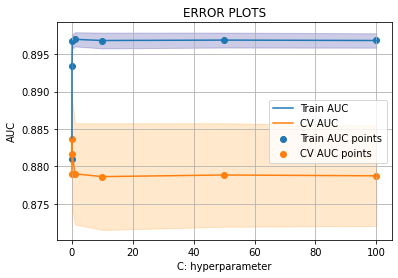

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

parameters = {'C': [10**-4, 10**-2, 10**-1, 1, 10,50,100]}
clf = GridSearchCV(LogisticRegression(), parameters, cv=skf, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_true)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['C'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['C'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['C'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['C'], train_auc, label='Train AUC points')
plt.scatter(parameters['C'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
clf.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# from the above graph we can see that C=1 is the best hyper-parameter. we will use this value to build the best LR model.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
# cross_validate returns scores which is a dict of float arrays of shape (n_splits,)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.515741,0.237316,1.093038,1.605543,1.608521,1.612386,1.659215
score_time,5.0,0.006977,0.000982,0.005286,0.007088,0.007189,0.007619,0.007703
test_score,5.0,0.881640,0.008016,0.876197,0.878318,0.878330,0.879537,0.895817
train_score,5.0,0.896711,0.001029,0.895945,0.896142,0.896345,0.896626,0.898496


__Summary__
1. We have got a pretty good mean test_score of 0.883

In [ ]:
# fit the model to the train data and then we will use it to predict for the test data
model.fit(X_tr, y_true)
predictions = model.predict_proba(X_te)[:,1]

In [ ]:
y_train_pred = model.predict(X_tr)
# y_test_pred = clf.predict(df_final_test)

In [ ]:
test = pd.read_csv('test.csv')
kaggle = pd.DataFrame()
kaggle["Id"] = test["id"]
kaggle["ACTION"] = predictions

kaggle.to_csv("data/target-encoding.csv", index = False)

## 9.2 Logistic regression with class weight = balanced

#### Hyper-Parameter tuning

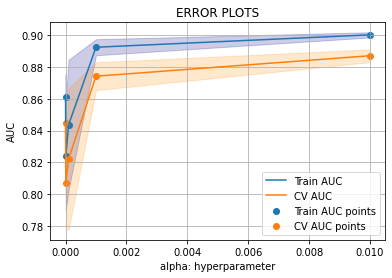

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

classifier = SGDClassifier(class_weight='balanced', penalty='l2',loss='log', random_state=42)

parameters = {'alpha': [10 ** x for x in range(-6, -1)]}
clf = GridSearchCV(classifier, parameters, cv=skf, scoring='roc_auc', return_train_score=True)

clf.fit(X_tr, y_true)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
clf.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
# from the above graph we can see that C=1 is the best hyper-parameter. we will use this value to build the best LR model.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

model = SGDClassifier(class_weight='balanced', alpha=1, penalty='l2', loss='log', random_state=42)
# cross_validate returns scores which is a dict of float arrays of shape (n_splits,)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.166447,1.673138,0.350034,0.357701,0.479727,0.487587,4.157188
score_time,5.0,0.005934,0.000711,0.005415,0.005588,0.005670,0.005819,0.007179
test_score,5.0,0.883443,0.007745,0.875168,0.878898,0.881498,0.886462,0.895188
train_score,5.0,0.886459,0.001743,0.883876,0.885614,0.887019,0.887488,0.888301


In [ ]:
model.fit(X_tr, y_true)
predictions = model.predict_proba(X_te)[:,1]

test = pd.read_csv('test.csv')
kaggle = pd.DataFrame()
kaggle["Id"] = test["id"]
kaggle["ACTION"] = predictions

kaggle.to_csv("data/LR_Balanced_truncated_svd_respose_coding_1_Components.csv", index = False)

## 9.3 Logistic regression without class balancing

#### Hyper-Parameter tuning

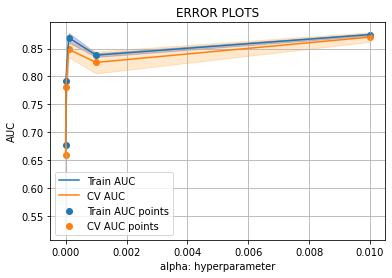

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

classifier = SGDClassifier( penalty='l2',loss='log', random_state=42)

parameters = {'alpha': [10 ** x for x in range(-6, -1)]}
clf = GridSearchCV(classifier, parameters, cv=skf, scoring='roc_auc', return_train_score=True)

clf.fit(X_tr, y_true)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
clf.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
# from the above graph we can see that C=1 is the best hyper-parameter. we will use this value to build the best LR model.

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

model = SGDClassifier(alpha=0.01, penalty='l2', loss='log', random_state=42)
# cross_validate returns scores which is a dict of float arrays of shape (n_splits,)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,3.152392,0.145884,2.979583,3.122849,3.134625,3.140285,3.384621
score_time,5.0,0.007931,0.001182,0.006977,0.007161,0.007562,0.008041,0.009916
test_score,5.0,0.870494,0.009649,0.863864,0.864417,0.866099,0.871110,0.886981
train_score,5.0,0.874968,0.002269,0.872552,0.873734,0.874475,0.875554,0.878525


In [ ]:
model.fit(X_tr, y_true)
predictions = model.predict_proba(X_te)[:,1]

test = pd.read_csv('test.csv')
kaggle = pd.DataFrame()
kaggle["Id"] = test["id"]
kaggle["ACTION"] = predictions

kaggle.to_csv("data/LR_UnBalanced_truncated_svd_respose_coding_100_Components.csv", index = False)

## 9.4 Linear Support Vector Machines

#### Hyper-Parameter tuning

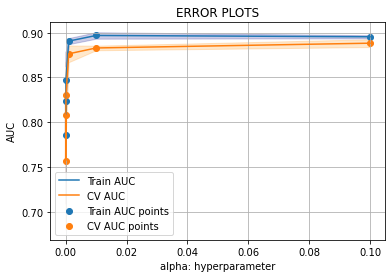

In [ ]:


# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

classifier = SGDClassifier(class_weight='balanced',penalty='l2',loss='hinge', random_state=42)

parameters = {'alpha': [10 ** x for x in range(-6, 0)]}
clf = GridSearchCV(classifier, parameters, cv=skf, scoring='roc_auc', return_train_score=True)

clf.fit(X_tr, y_true)

train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['alpha'], train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(parameters['alpha'], cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(parameters['alpha'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(parameters['alpha'], train_auc, label='Train AUC points')
plt.scatter(parameters['alpha'], cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

In [ ]:
clf.best_estimator_

SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:

model = SGDClassifier(class_weight='balanced',alpha=0.1, penalty='l2', loss='hinge', random_state=42)
# cross_validate returns scores which is a dict of float arrays of shape (n_splits,)
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.547916,0.067094,0.486790,0.489219,0.550983,0.561579,0.651011
score_time,5.0,0.006874,0.000506,0.005988,0.006925,0.007112,0.007158,0.007190
test_score,5.0,0.888272,0.004841,0.883043,0.884715,0.887172,0.891858,0.894571
train_score,5.0,0.895446,0.001950,0.892031,0.895791,0.896177,0.896340,0.896891


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
model.fit(X_tr, y_true)

calibrator = CalibratedClassifierCV(model, cv='prefit')
model=calibrator.fit(X_tr, y_true)

predictions = model.predict_proba(X_te)[:,1]

test = pd.read_csv('test.csv')
kaggle = pd.DataFrame()
kaggle["Id"] = test["id"]
kaggle["ACTION"] = predictions

kaggle.to_csv("data/SVC_truncated_svd_respose_coding_100_Components.csv", index = False)

__Summary__
1. test_score of 0.881927 is better than that of Linear Regression model

## 9.5 Random Forest

#### Hyper-Parameter tuning

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# How to take the log of all elements of a list: https://stackoverflow.com/questions/11656767/how-to-take-the-log-of-all-elements-of-a-list

folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
clf = RandomForestClassifier(random_state=0)
parameters = {'n_estimators': [1200], 'max_depth': [10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf':[1, 2, 4]}
clf = GridSearchCV(clf, parameters, cv=skf, scoring='roc_auc', return_train_score=True)
clf.fit(X_tr, y_true)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1001, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                          

In [ ]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.model_selection import cross_validate
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,196.765171,0.901852,195.576274,196.362392,196.690283,197.222080,197.974826
score_time,5.0,0.912664,0.021230,0.895527,0.901981,0.903008,0.914088,0.948716
test_score,5.0,0.905047,0.009044,0.894480,0.898510,0.903678,0.913932,0.914637
train_score,5.0,0.959425,0.002972,0.956063,0.957544,0.958468,0.962110,0.962940


In [ ]:
model.fit(X_tr, y_true)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:

# Predicting the test
predictions = model.predict_proba(X_te)[:,1]

test = pd.read_csv('test.csv')
kaggle = pd.DataFrame()
kaggle["Id"] = test["id"]
kaggle["ACTION"] = predictions

In [ ]:
kaggle.to_csv("svd-3/2-3-pairs-RandomForest_1200_depth-10(with freq feature-all features)_new.csv", index = False)

## 9.6 XGBoost

#### Using Randomized search cv

In [ ]:
# https://gist.github.com/wrwr/3f6b66bf4ee01bf48be965f60d14454d 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_test ={
              'max_depth': [15, 20, 25, 30],
             'learning_rate': [0.1, 0.01, 0.001],
             'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5],
              'n_estimators':  [80, 90, 100, 120, 140],
            }


#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = xgb.XGBClassifier()
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    scoring='roc_auc',
    cv=3,
    refit=True,
    return_train_score = True,
    random_state=314,
    verbose=True)

gs.fit(X_tr, y_true)

In [ ]:
print(gs.best_params_)

{'n_estimators': 100, 'max_depth': 20, 'learning_rate': 0.01, 'colsample_bytree': 0.4}


#### Building the model with best hyperparameters

In [ ]:
# fiiting the XGBoost with the best params
params = {'colsample_bytree': 0.4, 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 100, 'subsample': 1} 

model = xgb.XGBClassifier(
        objective= 'binary:logistic', 
        random_state = 101,
        **params
    )
model.fit(X_tr, y_true)

# Save the trained XGBoost model so as to use it in future on any given test data.
Pkl_Filename = "model_new_xgb.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

# Load the Model back from file
with open(Pkl_Filename, 'rb') as file:  
    model = pickle.load(file)
    
# Do predictions on the test data
predictions = model.predict_proba(X_te)[:,1]

# Make the result ready for Kaggle submission
test = pd.read_csv('test.csv')
kaggle = pd.DataFrame()
kaggle["Id"] = test["id"]
kaggle["ACTION"] = predictions

kaggle.to_csv("svd-3/2-3-pairs-XGBoost.csv", index = False)

#### Get the scores using cross_validate

In [ ]:
score = cross_validate(model, X_tr, y_true, groups=None, scoring='roc_auc', 
                       cv=skf, n_jobs=2, return_train_score = True)
score = pd.DataFrame(score) # we will store the score in a dataframe and then transpose this to find the mean test_score and mean train_score.

score.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,59.872466,2.340899,57.656624,58.266522,58.622036,62.370174,62.446974
score_time,5.0,0.116189,0.004768,0.111004,0.113331,0.115820,0.117202,0.123587
test_score,5.0,0.905478,0.010520,0.893933,0.899618,0.900921,0.913890,0.919025
train_score,5.0,0.971856,0.002513,0.968185,0.970691,0.972190,0.973802,0.974411


__Summary__
1. test_score of 0.905478, is better than rest of the models

# 10.Summarization using pretty tables

In [26]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Best HyperPrameter", "Mean Test Score", "Mean Train Score"]



x.add_row([" Logistic Regression", "C=0.01", 0.883655, 0.893479])
x.add_row([" Logistic regression with class balancing", "alpha=0.001", 0.883443, 0.886459])
x.add_row([" Logistic regression without class balancing", "alpha=0.001", 0.870494, 0.874968])


#x.add_row([" Linear Support Vector Machines", "alpha=0.001", 0.888272, 0.895446])

x.add_row([" Random Forest", "Max_depth=10, n_estimators=1200", 0.905047, 0.959425])

x.add_row([" ", " ", " " ,   " " ])
x.add_row([" XGBoost", " 'n_estimators': 100,", 0.905478 , 0.971856])
x.add_row([" ", " 'learning_rate': 0.01,", " " ,   " "])
x.add_row([" ", " 'colsample_bytree': 0.4,", " " ,   " "])
x.add_row([" ", " 'max_depth': 20", " " ,   " " ])


print(x)

+----------------------------------------------+---------------------------------+-----------------+------------------+
|                    Model                     |        Best HyperPrameter       | Mean Test Score | Mean Train Score |
+----------------------------------------------+---------------------------------+-----------------+------------------+
|              Logistic Regression             |              C=0.01             |     0.883655    |     0.893479     |
|   Logistic regression with class balancing   |           alpha=0.001           |     0.883443    |     0.886459     |
|  Logistic regression without class balancing |           alpha=0.001           |     0.870494    |     0.874968     |
|                 Random Forest                | Max_depth=10, n_estimators=1200 |     0.905047    |     0.959425     |
|                                              |                                 |                 |                  |
|                    XGBoost            

## 5. Conclusion


<ol>
<li>
<h3>Data-Preprocessing : </h3>
It's found that role_code and Role_title has same number of categories. Each role_code is mapped to unique value of role_title. Hence we can drop role_code and keep role_title.
After this we can perform Pair-wise column featurinzation. Here columns we combined in pairs of 2 and pairs of 3.
Total number of features after doing pair-wise featurization is 92. We can perform TruncatedSVD dimentionality reduction on top of one-hot encoding.
i.e- One-hot encoding was done on each column and SVD with n_components = 1 was done.
Therefor the total SVD features are 92. Hence total number of columns after the end of data-preprocessing is 92+92 = 184  
</li>

<li>
<h3>LOGISTIC REGRESSION</h3>
we can work with One-hot-encoded data in Logistic Regression. Logistic Regression can work well with high dimentionality data  as its easier to find planes in high dimentional data and its easier to separate classes.
First we try with class balancing. Since we are doing class balancing(we are doing oversampling). Class balancing also help the minor class get a better precision and recall.

<li>
<h3>LINEAR SVM</h3>
one of the big advantages of linear svm is that they are very interpretable and works very well for high dimentional data.We are also doing class balancing. Here we are not using RBF_kernel because we dont know which kernel will work well for this kind of data.RBF kernel is
also not very interpretable.
</li>

<li>
<h3>Random Forest</h3>
Decision tree donot work well with high dimentionala data, so we tried to implement a better version of Decision tree, called Random forest.
In Random Forest, if the number of estimators increase than the model will generalize better.
</li>

<li>
<h3>XGBoost</h3>
XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. Source: machinelearningmastery.com
</li>

</ol>

<h3>XGBoost model with 'colsample_bytree': 0.4,'eta': 0.01,'max_depth': 20, 'subsample': 1 gives the best AUC score</h3>
<h3>Kaggle Rank: 94</h3>